Data Analysis Pipeline:


*  Clone the repo to carry the dependencies over and to invoke imagene.py.
*  Import all necessary modules.


*   Read VCF file, extract the data, and create an ImaGene object.

*   Simulate data for early and moderate strength selection selrange = seq 0 300 300 / timerange = 0.1 100kya
*   Build and compile baseline model.


*   Train model on training data and gather metrics.

*   Test trained network on unseen data.
*  













In [1]:
# Cloning the GitHub repository
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Change directories into the specified directory
%cd EvoNet-CNN-Insight/Timing



Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 3509, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (240/240), done.
remote: Total 3509 (delta 244), reused 301 (delta 169), pack-reused 3100
Receiving objects: 100% (3509/3509), 4.74 GiB | 27.23 MiB/s, done.
Resolving deltas: 100% (1171/1171), done.
Updating files: 100% (227/227), done.
/content/EvoNet-CNN-Insight/Timing


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import arviz

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers



# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
import pydot  # Optional, but required by keras to plot the model

In [3]:
%run -i ImaGene.py

ImaGene uses msms to run simulations for training. Use ../generate_dataset.sh with ../params.txt (modify as needed).

params_earl_weak.txt simulates 200,000 loci (80kbp) under neutral evolution or positive selection (1.5% selection coefficient). Selection starts 800 generations ago with an allele frequency of 0.01. Mutation rate: 1.5e-8, recombination rate: 1e-8. Model follows Marth et al. 2004, sampling 198 chromosomal copies.

Specify directories for msms and simulation storage, then run the command. The script splits simulations into batches for training.

In [4]:
# if you wish to generate new training data, do not run otherwise
import subprocess
subprocess.call("bash ../generate_dataset.sh params_binary.txt".split());

In [5]:
path = './'

In [6]:

path_sim = './'

In [7]:
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Populate an ImaGene object by specifying the variable to estimate (selection_coeff_hetero) and the number of data points per class. Use 2000 data points per class as an example.

In [32]:
gene_sim = file_sim.read_simulations(parameter_name='selection_start_time', max_nrepl=2000);

In [34]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');


In [35]:
gene_sim.resize((198, 192));

In [36]:
gene_sim.convert(flip=True);


shuffle images before using them for training network.


In [37]:
gene_sim.subset(get_index_random(gene_sim));

In [38]:
gene_sim.targets = to_binary(gene_sim.targets);

In [39]:
gene_sim.save(file=path + 'gene_sim.binary')

0

In [40]:
gene_sim = load_imagene(file=path + 'gene_sim.binary')

Build and compile the model.

In [41]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [42]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

summary of the model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 196, 190, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 98, 95, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 93, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 44, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 22, 64)       

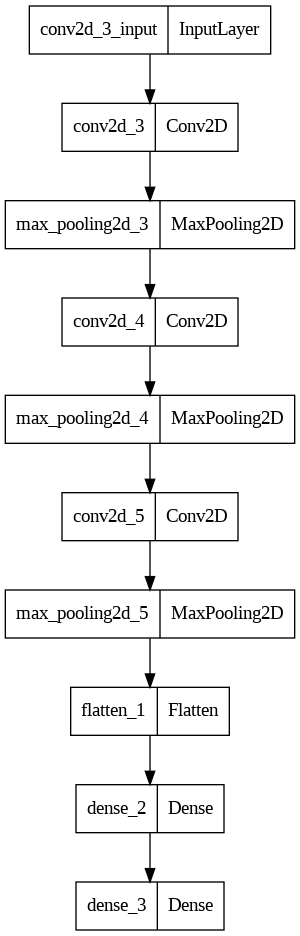

In [43]:
model.summary()
plot_model(model, path + 'net.binary.png')

In [44]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

train batches from 1-9

In [45]:
import csv


total_epochs = 0
losses = []
val_losses = []
accuracies = []
val_accuracies = []

i = 1
while i < 10:
    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=1, verbose=1, validation_split=0.10)

    # Append the loss, validation loss, accuracy, and validation accuracy values for each epoch
    losses.extend(score.history['loss'])
    val_losses.extend(score.history['val_loss'])
    accuracies.extend(score.history['accuracy'])
    val_accuracies.extend(score.history['val_accuracy'])

    # Update the total number of epochs trained
    total_epochs += len(score.history['loss'])

    net_LCT.update_scores(score)

    i += 1

# Print the total number of epochs
print(f'Total epochs trained: {total_epochs}')

# Save the loss, validation loss, accuracy, and validation accuracy to a CSV file
with open('training_metrics.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    for epoch in range(total_epochs):
        training_loss = losses[epoch] if epoch < len(losses) else ''
        validation_loss = val_losses[epoch] if epoch < len(val_losses) else ''
        training_accuracy = accuracies[epoch] if epoch < len(accuracies) else ''
        validation_accuracy = val_accuracies[epoch] if epoch < len(val_accuracies) else ''
        csvwriter.writerow([epoch + 1, training_loss, validation_loss, training_accuracy, validation_accuracy])

# Plot the loss and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), losses, label='Training Loss')
plt.plot(range(total_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Decay Over Epochs')
plt.legend()
plt.show()

# Plot the accuracy and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), accuracies, label='Training Accuracy')
plt.plot(range(total_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


1
29/29 [==============================] - 85s 3s/step - loss: 4.2573 - accuracy: 0.9644 - val_loss: 2.4471 - val_accuracy: 1.0000


KeyboardInterrupt: 

We can plot loss and validation accuracy during the training to check, for instance, for overfitting.

In [ ]:
net_LCT.plot_train()

We save (and/or load) the final trained model.

In [22]:
model.save(path + 'model.AS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model = load_model(path + 'model.AS.h5')

You can also save the network itself (and load it).

In [24]:
net_LCT.save(path + 'net_LCT.AS');

In [25]:
net_LCT = load_imanet(path + 'net_LCT.AS')

Finally, we evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [26]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'Binary/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test)
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

Let's report loss and accuracy on the testing set.

In [27]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test)  # it will report [loss, accuracy]



[0.06977493315935135, 1.0]


63/63 [==============================] - 26s 406ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


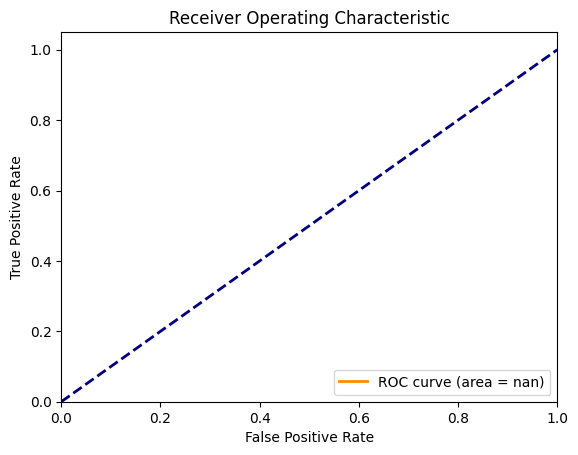

ValueError: not enough values to unpack (expected 4, got 1)

In [28]:
# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(gene_sim_test.targets, y_pred).ravel()

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

For a binary (or multiclass) classification, it is convenient to plot the confusion matrix after predicting the responses from the testing data.

63/63 [==============================] - 26s 406ms/step


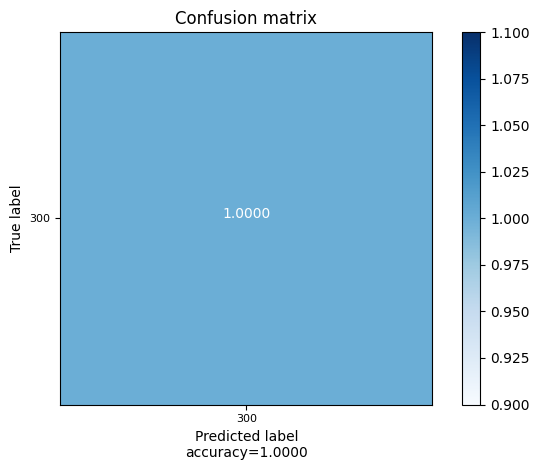

0

In [29]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

63/63 [==============================] - 29s 454ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


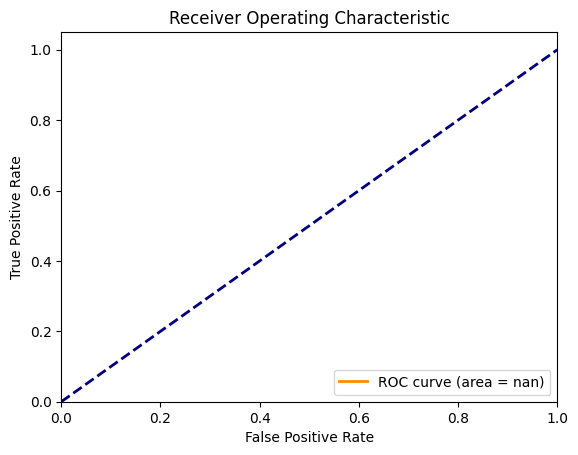

Unique values in gene_sim_test.targets: [0.]
Unique values in y_pred: [0]
Confusion matrix:
 [[2000]]
Error: Confusion matrix does not have 4 elements. Shape: (1, 1)
Sensitivity (Recall): 0.00
Specificity: 0.00
Precision: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [30]:

# Add the following code for ROC and AUC calculation and plotting
y_pred_prob = model.predict(gene_sim_test.data)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Check the unique values in targets and predictions
print("Unique values in gene_sim_test.targets:", np.unique(gene_sim_test.targets))
print("Unique values in y_pred:", np.unique(y_pred))

# Calculate confusion matrix
conf_matrix = confusion_matrix(gene_sim_test.targets, y_pred)
print("Confusion matrix:\n", conf_matrix)

# Handle the case where the confusion matrix doesn't have 4 elements
if conf_matrix.shape == (2, 2):
    tn, fp, fn, tp = conf_matrix.ravel()
else:
    # Print an error message if the confusion matrix is not of shape (2, 2)
    print("Error: Confusion matrix does not have 4 elements. Shape:", conf_matrix.shape)
    tn = fp = fn = tp = 0

# Calculate sensitivity (recall)
sensitivity = recall_score(gene_sim_test.targets, y_pred)

# Calculate specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate precision
precision = precision_score(gene_sim_test.targets, y_pred)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, y_pred)

# Print metrics
print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")


Shape of gene_sim_test.data: (2000, 198, 192, 1)
Shape of gene_sim_test.targets: (2000,)
Distribution of target labels: {0.0: 2000}
Displaying 5 samples of the data and their targets:
Sample 1:
Data: [[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [0.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [1.]]]
Target: 0.0
--------------------------------------------------
Sample 2:
Data: [[[1.]
  [0.]
  [1.]
  ...
  [1.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [1.]
  ...
  [1.]
  [0.]
  [0.]]

 [[1.]
  [0.]
  [1.]
  ...
  [1.]
  [0.]
  [0.]]

 ...

 [[1.]
  [0.]
  [1.]
  ...
  [1.]
  [1.]
  [0.]]

 [[0.]
  [1.]
  [1.]
  ...
  [1.]
  [0.]
  [0.]]

 [[0.]
  [1.]
  [1.]
  ...
  [0.]
  [1.]
  [0.]]]
Target: 0.0
--------------------------------------------------
Sample 3:
Data: [[[1.]
  [1.]
  [1.]
  ...
  [

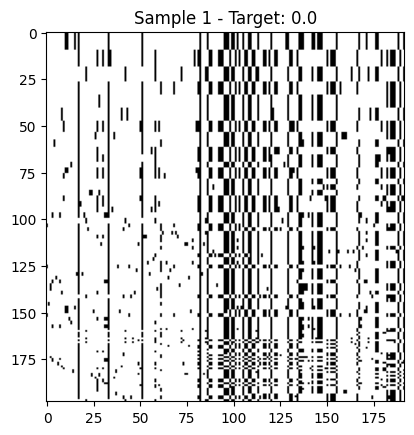

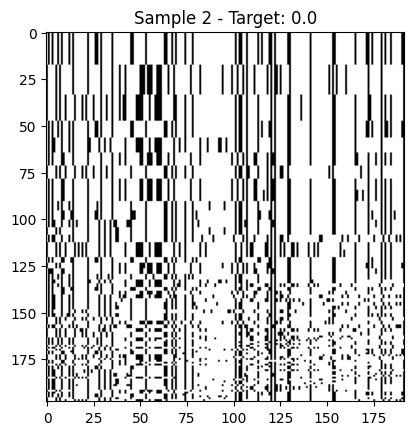

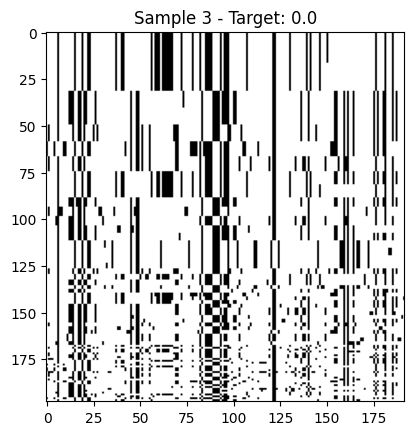

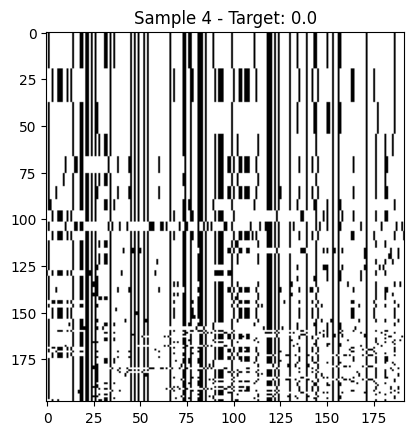

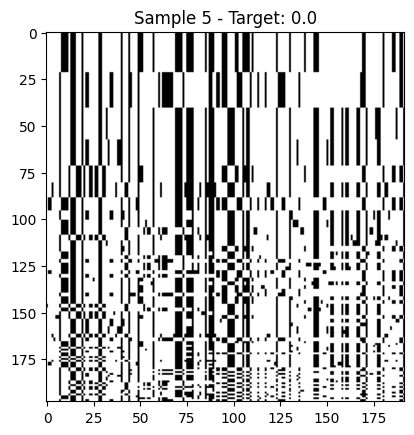

In [46]:
# Inspect the shape of the data and targets
print("Shape of gene_sim_test.data:", gene_sim_test.data.shape)
print("Shape of gene_sim_test.targets:", gene_sim_test.targets.shape)

# Check the distribution of the target labels
unique, counts = np.unique(gene_sim_test.targets, return_counts=True)
print("Distribution of target labels:", dict(zip(unique, counts)))

# Display a few samples of the data and their corresponding targets
num_samples_to_display = 5
print(f"Displaying {num_samples_to_display} samples of the data and their targets:")
for i in range(num_samples_to_display):
    print(f"Sample {i+1}:")
    print("Data:", gene_sim_test.data[i])
    print("Target:", gene_sim_test.targets[i])
    print("-" * 50)

# Verify the contents of the targets
print("Unique values in gene_sim_test.targets:", np.unique(gene_sim_test.targets))

# Verify the contents of the predicted probabilities
print("Sample predicted probabilities:", y_pred_prob[:num_samples_to_display])
print("Sample predicted labels:", y_pred[:num_samples_to_display])

# Additional check to ensure targets are binary
if len(np.unique(gene_sim_test.targets)) > 2:
    print("Warning: Targets are not binary. Unique values in targets:", np.unique(gene_sim_test.targets))

# Visualize the first few images if they are in a visualizable format (e.g., 2D images)
if len(gene_sim_test.data.shape) == 4 and gene_sim_test.data.shape[-1] == 1:  # Assuming data is (num_samples, height, width, 1)
    import matplotlib.pyplot as plt
    for i in range(num_samples_to_display):
        plt.imshow(gene_sim_test.data[i].squeeze(), cmap='gray')
        plt.title(f"Sample {i+1} - Target: {gene_sim_test.targets[i]}")
        plt.show()
